In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams["patch.force_edgecolor"] = True


In [59]:
df_original = pd.read_csv("sudeste.csv")

# Sample Data
Due to large data lets work with sampel data****

In [60]:
sample_df = df_original.sample(100000,random_state=101)

Dataset is too big so lets import in a chunk and work with the smallest one at first

## Info On Some Columns


1. Instant Air Temperature (celsius degrees) = temp
2. Maximum Air Temperature (celsius degrees) = tmin
3. Minimum Air Temperature (celsius degrees) = tmax
4. Relative Humidity of Air (%) =hmdy
5. Maximum Relative Air Humidity (%) =hmax
6. Minimum Relative Air Humidity (%) = hmin
7. Instant Dew Point (celsius degrees) = dewp
8. Maximum Dew Point (celsius degrees)=dmax
9. Minimum Dew Point Temperature (celsius degrees) = dmin
10. Instant Air Atmospheric Pressure (millibars) =stp
11. Maximum Air Atmospheric Pressure (millibars) = smax
12. Minimum Air Atmospheric Pressure (millibars)= smin
13. Instant Wind Speed (metres per second) = wdsp
14. Wind Direction (radius degrees) = wdct
15. Wind Gust Intensity (metres per second) = gust
16. Solar radiation  =  gbrd
17. Precipitation (milimetres) = prcp
18. Elevation = elvt
19. Observation Datetime = mdct
20. Observation Date = date
21. Station number (INMET number) for the location = inme
22. The year (2000-2016) : yr
23. The month (0-12) : mo
24. The day (0-31): da
25. The hour : hr

*Not all the columns are mentioned in this list*

In [61]:
sample_df.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
444352,307,SÃO MATEUS,29.0,-18.676198,-39.864051,A616,São Mateus,ES,2009-09-10 16:00:00,2009-09-10,...,28.4,19.6,26.9,18.0,58.0,63.0,55.0,4.6,92.0,7.7
9560222,420,PRADÓPOLIS,540.0,-21.338432,-48.114007,A747,Pradópolis,SP,2011-10-12 06:00:00,2011-10-12,...,20.9,19.2,20.4,18.4,88.0,90.0,87.0,4.1,135.0,7.1
8694523,409,JALES,460.0,-20.165025,-50.595134,A733,Jales,SP,2009-05-13 11:00:00,2009-05-13,...,21.7,15.8,20.0,14.6,69.0,71.0,69.0,1.2,84.0,3.9
9231502,415,ITAPIRA,635.0,-22.415062,-46.805292,A739,Itapira,SP,2016-07-05 14:00:00,2016-07-05,...,24.0,13.7,22.6,12.5,51.0,55.0,50.0,1.9,82.0,5.2
7955234,400,ITAPEVA,743.0,-23.981918,-48.885818,A714,Itapeva,SP,2014-02-15 18:00:00,2014-02-15,...,20.9,18.1,19.7,17.4,88.0,89.0,81.0,7.2,159.0,12.5


In [62]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 444352 to 5222905
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   wsid    100000 non-null  int64  
 1   wsnm    100000 non-null  object 
 2   elvt    100000 non-null  float64
 3   lat     100000 non-null  float64
 4   lon     100000 non-null  float64
 5   inme    100000 non-null  object 
 6   city    100000 non-null  object 
 7   prov    100000 non-null  object 
 8   mdct    100000 non-null  object 
 9   date    100000 non-null  object 
 10  yr      100000 non-null  int64  
 11  mo      100000 non-null  int64  
 12  da      100000 non-null  int64  
 13  hr      100000 non-null  int64  
 14  prcp    14488 non-null   float64
 15  stp     100000 non-null  float64
 16  smax    100000 non-null  float64
 17  smin    100000 non-null  float64
 18  gbrd    58007 non-null   float64
 19  temp    100000 non-null  float64
 20  dewp    99998 non-null   float64
 21  tmax

# Tidying Data

## Drop Elvt,Lat and Long

 Lat and long can correlate to city and province, so, remove elevation, longitude and lattitude 

In [63]:
sample_df.drop(['lat','lon', 'elvt'], axis=1,inplace=True)

In [64]:
print(sample_df.iloc[:,:10].head(1))
print("=="*20)
print(sample_df.iloc[:,10:20].head(1))
print("=="*20)

print(sample_df.iloc[:,20:].head(1))

        wsid        wsnm  inme        city prov                 mdct  \
444352   307  SÃO MATEUS  A616  São Mateus   ES  2009-09-10 16:00:00   

              date    yr  mo  da  
444352  2009-09-10  2009   9  10  
        hr  prcp     stp    smax    smin      gbrd  temp  dewp  tmax  dmax
444352  16   NaN  1017.7  1018.4  1017.7  2526.037  27.5  18.6  28.4  19.6
        tmin  dmin  hmdy  hmax  hmin  wdsp  wdct  gust
444352  26.9  18.0  58.0  63.0  55.0   4.6  92.0   7.7


In [65]:
sample_df.drop('wsnm', axis=1,inplace=True)

## Drop Multiple Time related columns

There are five columns on time of observatoin. They are mdct, date,yr, month and hour, which are same but separated into several sctions. Among them Date and Hour columns are useful and represent all in some form, so others can be dropped. The conversion of date column to datetime gave format error. So, first lets combine the yr,mo,da and hr columns to make one and then drop them

In [66]:
sample_df['date']=pd.to_datetime(sample_df[['yr', 'mo', 'da','hr']].rename(columns={'yr': 'year','mo': 'month','da': 'day','hr':'hour'}))

In [67]:
sample_df.drop(['mdct','yr','da','mo'], axis= 1, inplace=True)

In [313]:
sample_df.drop(['hr'], axis= 1, inplace=True)

Reset Index as Date column and the check for duplicates data on same date in same city and remove them

In [68]:
sample_df.set_index('date',inplace=True,drop=True)

Since there is no null values,under the assumption that all the data from various weather stations are valid and true, lets not filter the time of operation of weather stations and drop the wsids and inme, only city adn prov are enough.

In [69]:
sample_df.drop(['wsid','inme'],inplace=True, axis=1)

In [314]:
sample_df.head()

,city,prov,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
date,,,,,,,,,,,,,,,,,
2009-09-10 16:00:00,São Mateus,ES,1017.7,1018.4,1017.7,27.5,18.6,28.4,19.6,26.9,18.0,58.0,63.0,55.0,4.6,92.0,7.7
2011-10-12 06:00:00,Pradópolis,SP,949.3,949.7,949.2,20.4,18.4,20.9,19.2,20.4,18.4,88.0,90.0,87.0,4.1,135.0,7.1
2009-05-13 11:00:00,Jales,SP,961.9,961.9,961.2,21.7,15.8,21.7,15.8,20.0,14.6,69.0,71.0,69.0,1.2,84.0,3.9
2016-07-05 14:00:00,Itapira,SP,950.1,950.5,950.1,23.7,12.9,24.0,13.7,22.6,12.5,51.0,55.0,50.0,1.9,82.0,5.2
2014-02-15 18:00:00,Itapeva,SP,931.6,932.4,931.6,19.7,17.7,20.9,18.1,19.7,17.4,88.0,89.0,81.0,7.2,159.0,12.5


# Exploration and Manipulation

Text(0.5, 1.0, 'Weather Data by Province')

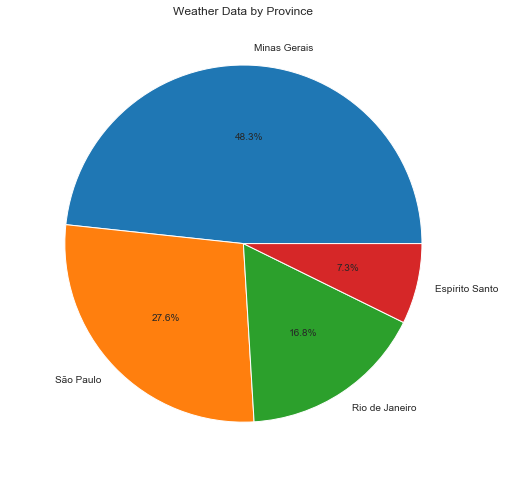

In [70]:
sample_df['prov'].value_counts(normalize=True).plot.pie(figsize=(8,10),autopct = '%.1f%%',labels=['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'])
plt.xlabel(" ")
plt.ylabel(" ")
# plt.legend(['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'], loc=0)
plt.title('Weather Data by Province')

In [71]:
sample_df.isnull().sum()

city        0
prov        0
hr          0
prcp    85512
stp         0
smax        0
smin        0
gbrd    41993
temp        0
dewp        2
tmax        1
dmax        4
tmin        0
dmin        9
hmdy        0
hmax        0
hmin        0
wdsp     9398
wdct        0
gust     3262
dtype: int64

## Missing Data Visualization Using Heatmap

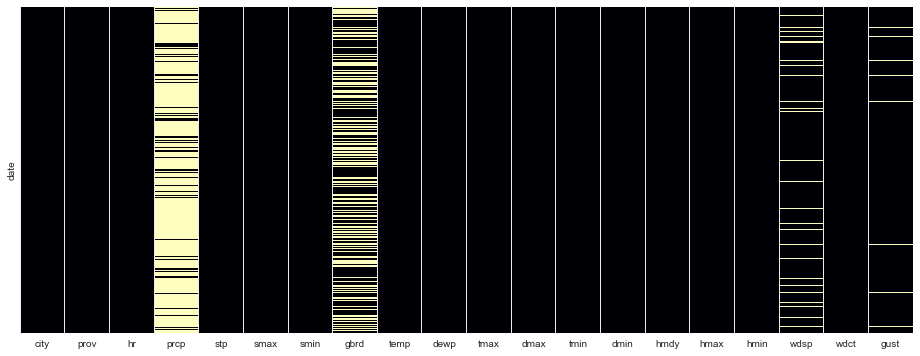

In [73]:
plt.figure(figsize=(16,6))
sns.heatmap(sample_df.isnull(),cmap='magma', cbar=False, yticklabels=False)

The figure shows that the prcp and gbrd have a lot of missing data. Lets check in actual percentage the amount of missing data. But heatmap cannot capture small percentage like tmin and tmax due to size difference.

## Missing data percentage calculation

Reutrn the columns with null values greater than 40% of total length of df.

 $((sample_df[col].isna().sum()*100) / df.shape[0])$ gives the null percentage of the relevant column.
 
  $sample_df[col].isna().sum() > round(0.4 * df.shape[0])$ checks if null percentage is more than 40% of toal length.Finally gives col and null percentage as key and value pair if the null amount is more thank 40 percentage

In [74]:
columns_40_percent_plus_null = {col:((sample_df[col].isna().sum()*100)/ sample_df.shape[0]) for col in sample_df.columns if sample_df[col].isna().sum() > 
                                round(0.4 * sample_df.shape[0]) }

In [75]:
columns_40_percent_plus_null

{'prcp': 85.512, 'gbrd': 41.993}

lets Drop both gbrd and prcp columns. And also nan rows from  temp,tmax,tmin columns since its really small.

In [76]:
sample_df.drop(['prcp','gbrd'], inplace=True,axis=1)

In [77]:
sample_df.dropna(subset=['tmax','temp','tmin'],inplace=True)

Just for the sake of argument fill the missing values in dewp, dmax with average values

In [78]:
sample_df['dmax'].fillna(sample_df['dmax'].mean(),inplace=True)
sample_df['dewp'].fillna(sample_df['dewp'].mean(),inplace=True)
sample_df['dmin'].fillna(sample_df['dmin'].mean(),inplace=True)

In [79]:
sample_df.isnull().sum()

city       0
prov       0
hr         0
stp        0
smax       0
smin       0
temp       0
dewp       0
tmax       0
dmax       0
tmin       0
dmin       0
hmdy       0
hmax       0
hmin       0
wdsp    9398
wdct       0
gust    3262
dtype: int64

### Windspeed and Gust Column missing vals

This [article](https://sciencing.com/winds-formed-5145233.html) suggests that wind-speed is affected by temperature and air pressure. So,lets find mean of windspeed between range of temp fill nans accordingly.

This [article](http://www.differencebetween.net/science/nature/difference-between-gust-and-wind/#:~:text=A%20gust%20is%20a%20sudden,comes%20in%202%2Dminute%20intervals.&text=A%20gust%20and%20wind%20both,earth's%20atmosphere%20around%20the%20earth.) suggest that gust is sudden change in windspeed due to terrain. So, using instant temperature to weighted mean to replace nans seems feaible for gust

In [81]:
sample_df['temp'].value_counts(bins=5).sort_index()

(-3.447, 5.82]     6623
(5.82, 15.04]      8143
(15.04, 24.26]    56291
(24.26, 33.48]    27821
(33.48, 42.7]      1121
Name: temp, dtype: int64

Instead of looping throuh ranges 10 intervals , lets just use 5 intervals like above

In [82]:
# Create five ranges of mean according to above interval for windspeed

first_range_mean_wdsp= sample_df[((sample_df['temp']>=-3.447) & (sample_df['temp']<5.82)) ]['wdsp'].mean()
second_range_mean_wdsp= sample_df[((sample_df['temp']>=5.82) & (sample_df['temp']<15.04))  ]['wdsp'].mean()
third_range_mean_wdsp= sample_df[((sample_df['temp']>=15.04) & (sample_df['temp']<24.26))  ]['wdsp'].mean()
fourth_range_mean_wdsp= sample_df[((sample_df['temp']>=24.26) & (sample_df['temp']<33.48))  ]['wdsp'].mean()
fifth_range_mean_wdsp= sample_df[((sample_df['temp']>=33.48) & (sample_df['temp']<42.7)) ]['wdsp'].mean()

In [83]:
# Create five ranges of mean according to above interval for airpressure

first_range_mean_gust= sample_df[((sample_df['temp']>=-3.447) & (sample_df['temp']<5.82)) ]['gust'].mean()
second_range_mean_gust= sample_df[((sample_df['temp']>=5.82) & (sample_df['temp']<15.04))  ]['gust'].mean()
third_range_mean_gust= sample_df[((sample_df['temp']>=15.04) & (sample_df['temp']<24.26))  ]['gust'].mean()
fourth_range_mean_gust= sample_df[((sample_df['temp']>=24.26) & (sample_df['temp']<33.48))  ]['gust'].mean()
fifth_range_mean_gust= sample_df[((sample_df['temp']>=33.48) & (sample_df['temp']<42.7)) ]['gust'].mean()

In [84]:
print(first_range_mean_wdsp, second_range_mean_wdsp,third_range_mean_wdsp,fourth_range_mean_wdsp,fifth_range_mean_wdsp)
print(first_range_mean_gust, second_range_mean_gust,third_range_mean_gust,fourth_range_mean_gust,fifth_range_mean_gust)

0.04393777642214428 1.8885478342162743 1.998070520277601 2.474517157322322 2.4622504537205057
0.10679405520169853 3.809891143663473 4.432743052349683 5.775794808225169 6.443202146690513


Create a function to fill missing values

In [85]:
# this funciton will take two cols, temp and wdsp in this order
#math is imported to check nan, np.nan wont work
def fill_missing_wdsp(col):
    import math
#Initialize relevant cols
    temp = col[0]
    wdsp = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    if math.isnan(wdsp):
        if(temp<5.82):
            return first_range_mean_wdsp
        elif(temp>=5.82) and (temp<15.04):
            return second_range_mean_wdsp
        elif(temp>=15.04) and (temp<24.26):
            return third_range_mean_wdsp
        elif(temp>=24.26) and (temp<33.48):
            return fourth_range_mean_wdsp
        elif(temp>=33.48):
            return fifth_range_mean_wdsp
        #if not nan return as it is
    else:
        return wdsp
    
    

In [86]:
# this funciton will take two cols, temp and gust in this order
#math is imported to check nan, np.nan wont work
def fill_missing_gust(col):
    import math
#Initialize relevant cols
    temp = col[0]
    gust = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    if math.isnan(gust):
        if(temp<5.82):
            return first_range_mean_gust
        elif(temp>=5.82) and (temp<15.04):
            return second_range_mean_gust
        elif(temp>=15.04) and (temp<24.26):
            return third_range_mean_gust
        elif(temp>=24.26) and (temp<33.48):
            return fourth_range_mean_gust
        elif(temp>=33.48):
            return fifth_range_mean_gust
        #if not nan return as it is
    else:
        return gust
    

In [87]:
sample_df['wdsp'] = sample_df[['temp','wdsp']].apply(fill_missing_wdsp,axis=1)
sample_df['gust'] = sample_df[['temp','gust']].apply(fill_missing_gust,axis=1)

# Data Analysis

### Extracting Air Pressure Table

In [88]:
air=sample_df[['city','prov','stp','smax','smin']]

In [89]:
air.head()

,city,prov,stp,smax,smin
date,,,,,
2009-09-10 16:00:00,São Mateus,ES,1017.7,1018.4,1017.7
2011-10-12 06:00:00,Pradópolis,SP,949.3,949.7,949.2
2009-05-13 11:00:00,Jales,SP,961.9,961.9,961.2
2016-07-05 14:00:00,Itapira,SP,950.1,950.5,950.1
2014-02-15 18:00:00,Itapeva,SP,931.6,932.4,931.6


#### Table to find out mean, min, max of smax for each city monthly

In [224]:
pd.crosstab(index=air.index.month,columns=air.city,values=air.smax,aggfunc=['min','max']).stack()

min     max
row_0 city                           
1     Afonso Cláudio      0.0   960.5
      Aimorés             0.0   995.8
      Alegre            993.1  1004.1
      Alfredo Chaves      0.0  1015.4
      Almenara            0.0   996.9
...                       ...     ...
12    Varginha            0.0   912.0
      Vitória          1005.0  1017.5
      Viçosa              0.0   940.8
      Votuporanga         0.0   961.9
      Águas Vermelhas     0.0   934.1

[1372 rows x 2 columns]

#### Table to find out mean, min, max of smin for each city monthly

In [223]:
pd.crosstab(index=air.index.month,columns=air.city,values=air.smin,aggfunc=['min','max']).stack()

min     max
row_0 city                           
1     Afonso Cláudio      0.0   959.9
      Aimorés             0.0   995.0
      Alegre            992.5  1003.7
      Alfredo Chaves      0.0  1014.7
      Almenara            0.0   996.4
...                       ...     ...
12    Varginha            0.0   911.5
      Vitória          1004.7  1017.2
      Viçosa              0.0   940.5
      Votuporanga         0.0   960.8
      Águas Vermelhas     0.0   933.7

[1372 rows x 2 columns]

In [92]:
air['city'].unique()

array(['São Mateus', 'Pradópolis', 'Jales', 'Itapira', 'Itapeva',
       'Viçosa', 'Juiz de Fora', 'José Bonifácio', 'Mantena',
       'Barra do Turvo', 'Campos do Jordão', 'São João del Rei',
       'Formiga', 'Camanducaia', 'Aimorés', 'Avaré', 'Salinas',
       'Duque de Caxias', 'Timóteo', 'Bauru', 'João Pinheiro', 'Muriaé',
       'Governador Valadares', 'Pirapora', 'Rio de Janeiro',
       'Campos dos Goytacazes', 'Teófilo Otoni', 'Caldas',
       'Montes Claros', 'Cambuci', 'Franca', 'Ituverava', 'Três Marias',
       'Montalvânia', 'Rancharia', 'Arraial do Cabo', 'Curvelo',
       'Caratinga', 'Araxá', 'São Gonçalo', 'Casa Branca',
       'São Luís do Paraitinga', 'Passos', 'Linhares', 'Campina Verde',
       'Ibirité', 'São Miguel Arcanjo', 'Resende', 'Teresópolis',
       'Guanhães', 'Barra Bonita', 'Sorocaba', 'Porteirinha',
       'Chapada Gaúcha', 'São Romão', 'Taubaté', 'Coronel Pacheco',
       'Alegre', 'Guarujá', 'Seropédica', 'Serra dos Aimorés',
       'Águas Vermelha

In [93]:
air.index.year.unique()

Int64Index([2009, 2011, 2016, 2014, 2007, 2006, 2015, 2008, 2004, 2010, 2005,
            2012, 2013, 2003, 2002, 2001, 2000],
           dtype='int64', name='date')

#### Find out the mean air pressure (instant) values yearly for the chosen city and plot it 

Create the function with the input value is the city name then it shows its data table for average air pressure (instant) yearly and line chart

In [327]:
def pressure_city_yearly(val):
    b=air[air['city']==val]
    yearly=b.groupby(b.index.year)['stp'].agg('mean')
    print(val)
    print(yearly)
    plt.figure(figsize=(12,5))
    yearly.plot(kind='line',color='blue',linewidth=2)
    plt.title('Yearly average temperature °C in {}'.format(val))
    plt.show()

Espinosa
date
2007    852.990000
2008    950.197590
2009    949.346512
2010    950.225610
2011    949.931522
2012    949.922368
2013    798.532979
2014    816.346739
2015    950.777895
2016    950.733898
Name: stp, dtype: float64


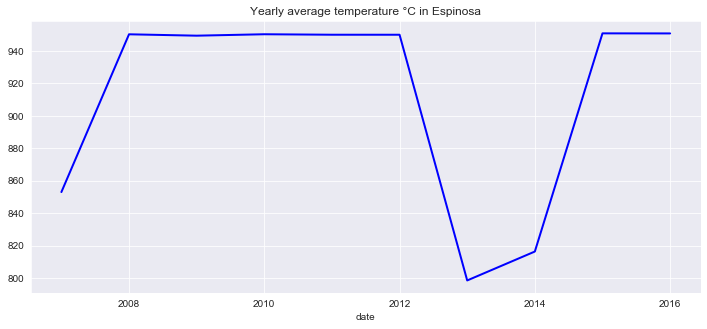

In [328]:
pressure_city_yearly('Espinosa')

Afonso Cláudio
date
2011    905.389474
2012    855.070968
2013    696.708081
2014    957.713483
2015    905.397802
2016    712.638462
Name: stp, dtype: float64


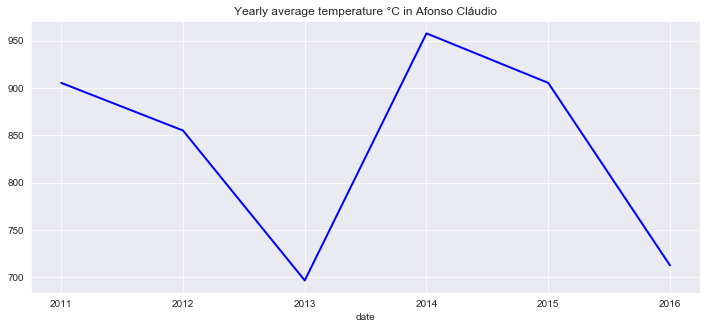

In [329]:
pressure_city_yearly('Afonso Cláudio')

Juiz de Fora
date
2007    858.607692
2008    911.222727
2009    910.590110
2010    891.038462
2011    900.038554
2012    912.516471
2013    911.543011
2014    912.043750
2015    912.224742
2016    912.280645
Name: stp, dtype: float64


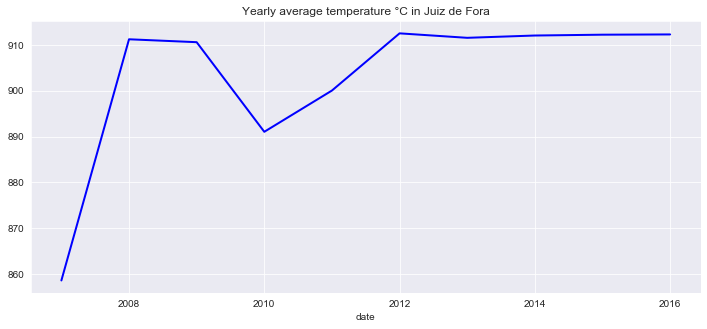

In [330]:
pressure_city_yearly('Juiz de Fora')

#### Table of mean of smax and smin in each city yearly

This table shows the average highest and lowest pressure of each city yearly

In [98]:
air.pivot_table(index=air.index.year,columns='city',values=['smax','smin'],aggfunc='mean').stack()

smax         smin
date city                                     
2000 Seropédica        922.787500   922.319643
2001 Bauru             941.060606   940.472727
     Seropédica        788.363559   787.982203
2002 Almenara          993.900000   993.450000
     Araxá             900.033333   897.800000
...                           ...          ...
2016 Varginha          505.842857   505.538095
     Vitória          1017.429688  1016.918750
     Viçosa            938.461194   938.008955
     Votuporanga       961.327632   960.790789
     Águas Vermelhas   749.198485   748.772727

[1188 rows x 2 columns]

#### Sketching the chart for specific air pressure values with year, month and city

Create a function which shows the data from given year, month and city name then plots it 

In [125]:
def monthly_plot(m,y,c):
    air_m_y=air[(air.index.month == m) & (air.index.year == y)]
    air_m_y_c=air_m_y[air_m_y['city']==c]
    air_m_y_c=air_m_y_c.sort_index(ascending=True)
    print(air_m_y_c)
    fig=plt.figure(figsize=(16,6))
    air_m_y_c['stp'].plot(kind='line',color='red')
    plt.title('{}-{} {}'.format(y,m,c))

                            city prov    stp   smax   smin
date                                                      
2008-10-05 05:00:00  São Gonçalo   RJ  984.9  984.9  984.7
2008-10-07 09:00:00  São Gonçalo   RJ  989.0  989.0  988.0
2008-10-08 22:00:00  São Gonçalo   RJ  984.1  984.1  983.6
2008-10-09 02:00:00  São Gonçalo   RJ  986.2  986.2  985.8
2008-10-10 02:00:00  São Gonçalo   RJ  985.9  986.0  985.7
2008-10-10 08:00:00  São Gonçalo   RJ  986.4  986.4  985.3
2008-10-14 11:00:00  São Gonçalo   RJ  986.0  986.1  985.6
2008-10-21 22:00:00  São Gonçalo   RJ  984.6  984.6  984.0
2008-10-23 21:00:00  São Gonçalo   RJ  983.9  983.9  983.3
2008-10-24 12:00:00  São Gonçalo   RJ  989.1  989.2  989.0
2008-10-25 05:00:00  São Gonçalo   RJ  986.6  986.7  986.5
2008-10-28 04:00:00  São Gonçalo   RJ  984.3  984.8  984.3


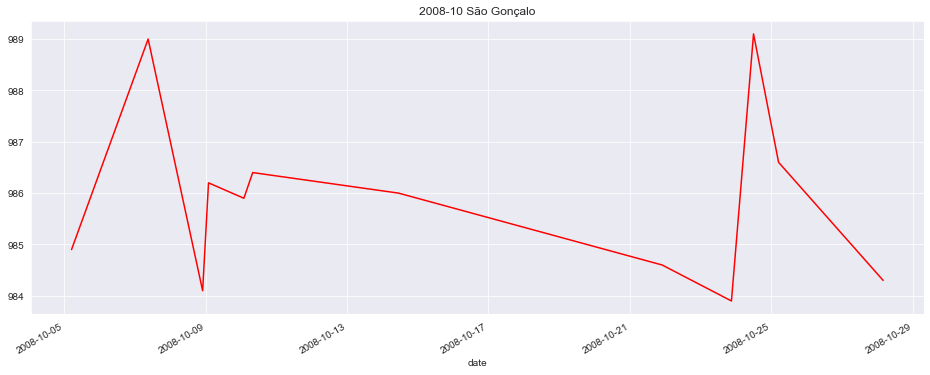

In [126]:
monthly_plot(10,2008,'São Gonçalo')

                               city prov    stp   smax   smin
date                                                         
2009-01-01 09:00:00  José Bonifácio   SP  965.7  965.7  965.3
2009-01-06 06:00:00  José Bonifácio   SP  962.6  962.9  962.6
2009-01-12 10:00:00  José Bonifácio   SP  967.1  967.1  966.7
2009-01-17 08:00:00  José Bonifácio   SP  962.6  962.6  962.4
2009-01-18 15:00:00  José Bonifácio   SP  966.3  966.6  966.2


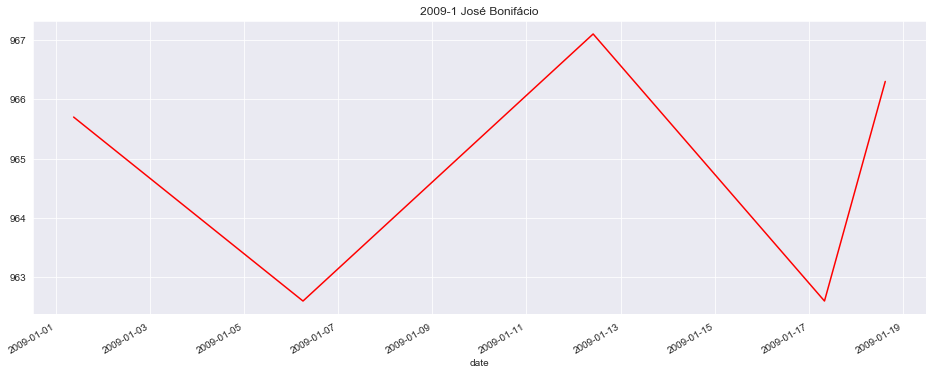

In [127]:
monthly_plot(1,2009,'José Bonifácio')

### Extracting temperature table

In [132]:
sample_df.head()

,city,prov,hr,stp,smax,smin,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
date,,,,,,,,,,,,,,,,,,
2009-09-10 16:00:00,São Mateus,ES,16,1017.7,1018.4,1017.7,27.5,18.6,28.4,19.6,26.9,18.0,58.0,63.0,55.0,4.6,92.0,7.7
2011-10-12 06:00:00,Pradópolis,SP,6,949.3,949.7,949.2,20.4,18.4,20.9,19.2,20.4,18.4,88.0,90.0,87.0,4.1,135.0,7.1
2009-05-13 11:00:00,Jales,SP,11,961.9,961.9,961.2,21.7,15.8,21.7,15.8,20.0,14.6,69.0,71.0,69.0,1.2,84.0,3.9
2016-07-05 14:00:00,Itapira,SP,14,950.1,950.5,950.1,23.7,12.9,24.0,13.7,22.6,12.5,51.0,55.0,50.0,1.9,82.0,5.2
2014-02-15 18:00:00,Itapeva,SP,18,931.6,932.4,931.6,19.7,17.7,20.9,18.1,19.7,17.4,88.0,89.0,81.0,7.2,159.0,12.5


In [133]:
from pandas.plotting import scatter_matrix

Check out the correlation between temperature (temp) and dew point (dewp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019ED2644FC8>,
      dtype=object)

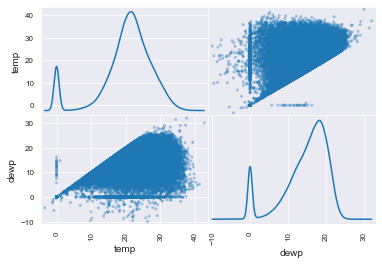

In [136]:
scatter_matrix(sample_df[['temp','dewp']],alpha=0.4,diagonal='kde')

Temperature table for analyzing

In [137]:
temperature=sample_df[['city','temp','tmax','tmin']]

In [141]:
temperature.sort_index(ascending=True,inplace=True)

In [142]:
temperature.head()

,city,temp,tmax,tmin
date,,,,
2000-05-27 06:00:00,Seropédica,0.0,0.0,0.0
2000-05-28 23:00:00,Seropédica,0.0,0.0,0.0
2000-05-29 12:00:00,Seropédica,0.0,0.0,0.0
2000-06-17 03:00:00,Seropédica,17.4,18.3,16.8
2000-06-20 16:00:00,Seropédica,29.7,30.7,29.4


Table shows the mean temperature and max temperature (instant) in each city yearly

In [180]:
temperature.pivot_table(index=temperature.index.year,columns='city',values='temp',aggfunc=['mean','max']).stack()

mean   max
date city                            
2000 Seropédica       20.366071  30.9
2001 Bauru            22.021212  32.7
     Seropédica       20.018644  33.9
2002 Almenara         26.950000  30.2
     Araxá            22.966667  26.5
...                         ...   ...
2016 Varginha         11.701587  28.4
     Vitória          24.223437  33.4
     Viçosa           20.244776  29.4
     Votuporanga      23.042105  34.9
     Águas Vermelhas  16.731818  29.9

[1188 rows x 2 columns]

Table shows max value and min value of tmax and tmin in each city yearly

In [179]:
temperature.pivot_table(index=temperature.index.year,columns='city',values=['tmax','tmin'],aggfunc=['max','min']).stack()

max         min      
                      tmax  tmin  tmax  tmin
date city                                   
2000 Seropédica       31.9  30.9   0.0   0.0
2001 Bauru            33.0  31.8  15.1  14.6
     Seropédica       36.0  33.3   0.0   0.0
2002 Almenara         31.5  29.9  23.7  23.1
     Araxá            26.5  24.9  19.2  18.9
...                    ...   ...   ...   ...
2016 Varginha         29.9  27.6   0.0   0.0
     Vitória          33.4  32.9  18.6  17.5
     Viçosa           30.5  29.3  10.0   9.1
     Votuporanga      35.6  34.3   9.7   8.7
     Águas Vermelhas  30.4  27.7   0.0   0.0

[1188 rows x 4 columns]

Create a function with given city value to show the table of max value of temp, tmin, tmax weekly and display a chart

In [217]:
def temp_analysis(city):
    c=temperature[temperature['city']==city]
    print(city)
    print(c)
    d=c.resample('W').agg('max')
    plt.figure(figsize=(15,10))
    d['tmax'].plot(kind='line',color='green');
    plt.show()

Vitória
                        city  temp  tmax  tmin
date                                          
2006-11-03 00:00:00  Vitória  24.7  25.0  24.7
2006-11-08 22:00:00  Vitória  21.8  22.8  21.8
2006-11-13 08:00:00  Vitória  19.8  19.9  19.5
2006-11-16 15:00:00  Vitória  28.4  28.6  26.8
2006-11-26 06:00:00  Vitória  20.9  21.3  20.7
...                      ...   ...   ...   ...
2016-09-07 06:00:00  Vitória  22.8  22.9  22.7
2016-09-07 15:00:00  Vitória  28.5  30.1  28.2
2016-09-09 03:00:00  Vitória  22.7  23.4  22.7
2016-09-13 07:00:00  Vitória  22.7  22.8  22.7
2016-09-19 10:00:00  Vitória  24.1  24.1  22.4

[945 rows x 4 columns]


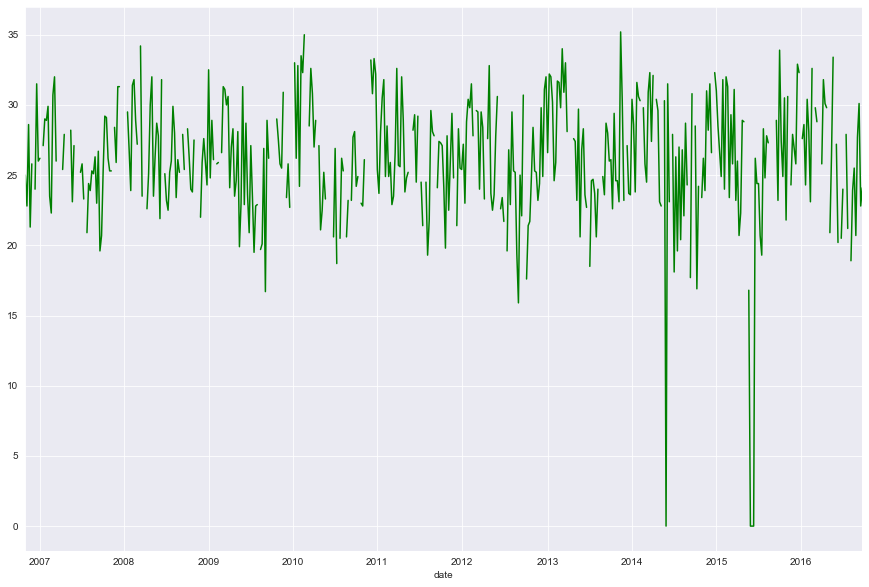

In [218]:
temp_analysis('Vitória')

Águas Vermelhas
                                city  temp  tmax  tmin
date                                                  
2007-09-09 22:00:00  Águas Vermelhas  19.1  20.8  19.1
2007-09-12 01:00:00  Águas Vermelhas  17.5  18.2  17.5
2007-09-15 03:00:00  Águas Vermelhas  12.2  14.0  12.2
2007-09-16 06:00:00  Águas Vermelhas  15.5  16.3  13.7
2007-09-19 14:00:00  Águas Vermelhas  20.9  21.6  19.7
...                              ...   ...   ...   ...
2016-09-13 23:00:00  Águas Vermelhas  20.0  22.6  20.0
2016-09-17 15:00:00  Águas Vermelhas  28.8  29.2  27.3
2016-09-19 12:00:00  Águas Vermelhas  22.6  22.6  20.0
2016-09-20 12:00:00  Águas Vermelhas  24.0  24.1  20.8
2016-09-30 10:00:00  Águas Vermelhas  16.5  16.7  14.4

[831 rows x 4 columns]


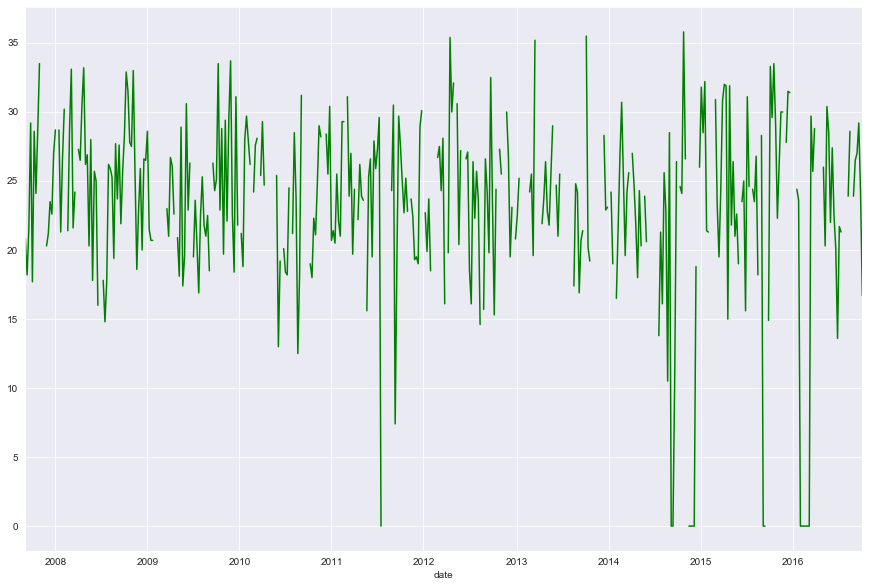

In [219]:
temp_analysis('Águas Vermelhas')

#### Coldest and hottest city in the year

In [210]:
cold_hot=temperature.pivot_table(index=temperature.index.year,columns='city',values='temp',aggfunc=['min','max']).stack()

In [212]:
cold_hot

min   max
date city                       
2000 Seropédica        0.0  30.9
2001 Bauru            15.1  32.7
     Seropédica        0.0  33.9
2002 Almenara         23.7  30.2
     Araxá            19.2  26.5
...                    ...   ...
2016 Varginha          0.0  28.4
     Vitória          18.3  33.4
     Viçosa            9.3  29.4
     Votuporanga       8.8  34.9
     Águas Vermelhas   0.0  29.9

[1188 rows x 2 columns]

Find out the hottest city in all years

In [220]:
cold_hot[cold_hot['max']==cold_hot['max'].max()]

,,min,max
date,city,,
2012,Afonso Cláudio,11.8,42.7


Find out the coldest city in all years

In [222]:
cold_hot[cold_hot['min']==cold_hot['min'].min()]

,,min,max
date,city,,
2011,Camanducaia,-3.4,22.8


- Find out coldest and hottest city in a month by given specific year and month using temperature temp (instant)
- Randomly choose 10 cities and plot the temperature chart in that month

In [315]:
def search_temp(ye,mo):
    search=temperature[(temperature.index.year==ye) & (temperature.index.month==mo)]
    s=search.pivot_table(index=search.index.month,columns='city',values='temp',aggfunc='max').stack()
    print(s)
    print('='*50)
    maxx=s[s==s.max()]
    minn=s[s==s.min()]
    random=s.sample(10)
    plt.figure(figsize=(9,6))
    random.plot(kind='barh',color='pink')
    plt.title('{}-{} Temperature °C'.format(mo,ye))
    print(random)
    print('Hottest city in {}-{} is: {}'.format(mo,ye,maxx))
    print('='*50)
    print('Coldest city in {}-{} is: {}'.format(mo,ye,minn))

date  city           
3     Afonso Cláudio     31.3
      Aimorés            33.9
      Alegre             33.1
      Alfredo Chaves     31.7
      Almenara           29.7
                         ... 
      Varginha           28.2
      Vitória            28.5
      Viçosa             28.7
      Votuporanga        29.4
      Águas Vermelhas    29.1
Length: 113, dtype: float64
date  city                
3     Barra Bonita            22.5
      Timóteo                 29.4
      Ituverava               31.0
      Governador Valadares    31.6
      José Bonifácio          32.9
      Ibitinga                28.2
      Jales                   30.6
      Guanhães                27.6
      Casa Branca             28.6
      Caratinga               29.1
dtype: float64
Hottest city in 3-2016 is: date  city      
3     Seropédica    35.9
dtype: float64
Coldest city in 3-2016 is: date  city        
3     Guarujá         0.0
      Passa Quatro    0.0
      Petrópolis      0.0
dtype: float64


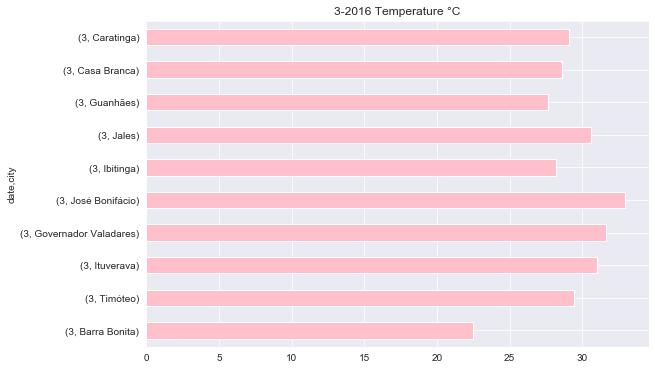

In [316]:
search_temp(2016,3)

date  city           
3     Aimorés            34.0
      Alegre             37.8
      Alfredo Chaves     32.2
      Almenara           28.8
      Araxá              28.8
                         ... 
      Varginha           28.8
      Vitória            31.1
      Viçosa             23.8
      Votuporanga        29.5
      Águas Vermelhas    31.1
Length: 103, dtype: float64
date  city            
3     Franca               0.0
      São Gonçalo          0.0
      Pirapora            31.1
      Porteirinha         30.9
      Parati              29.6
      Santa Teresa        26.4
      Ituiutaba           29.9
      São João del Rei    26.2
      Vitória             31.1
      Formiga             31.6
dtype: float64
Hottest city in 3-2009 is: date  city  
3     Alegre    37.8
dtype: float64
Coldest city in 3-2009 is: date  city            
3     Barra do Turvo      0.0
      Campos do Jordão    0.0
      Franca              0.0
      Ituverava           0.0
      São Gonçalo         

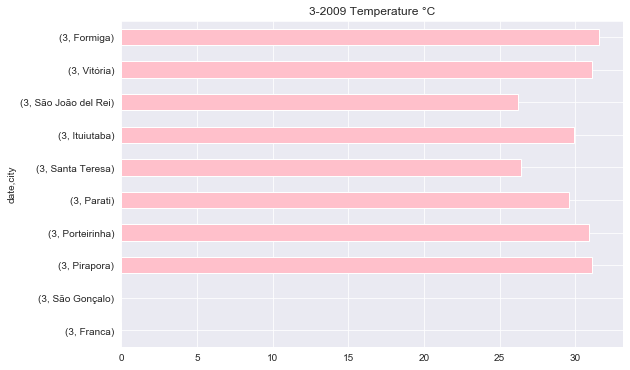

In [317]:
search_temp(2009,3)

date  city           
11    Aimorés            29.8
      Alegre             29.6
      Alfredo Chaves     31.8
      Almenara           28.0
      Araxá              26.7
                         ... 
      Varginha           25.0
      Vitória            29.1
      Viçosa             25.6
      Votuporanga        27.1
      Águas Vermelhas    27.9
Length: 106, dtype: float64
date  city              
11    Parati                24.9
      Barra Bonita          29.0
      São Miguel Arcanjo    27.2
      Avaré                 27.7
      Resende               23.6
      São Mateus            23.7
      Teófilo Otoni         24.4
      Capelinha             23.0
      Rio de Janeiro        28.4
      Montalvânia           24.5
dtype: float64
Hottest city in 11-2010 is: date  city   
11    Cambuci    34.3
dtype: float64
Coldest city in 11-2010 is: date  city      
11    Petrópolis    15.6
dtype: float64


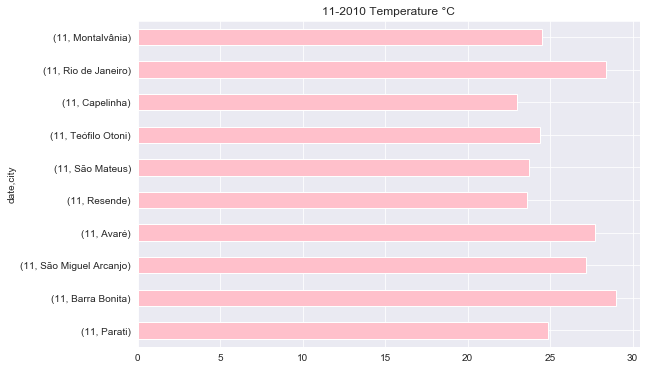

In [318]:
search_temp(2010,11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E3A545F08>,
      dtype=object)

<Figure size 1008x432 with 0 Axes>

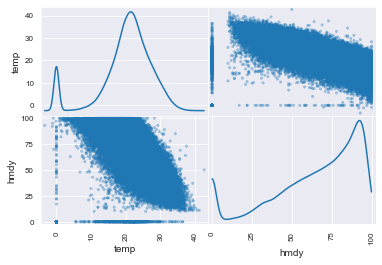

In [312]:
plt.figure(figsize=(14,6))
scatter_matrix(sample_df[['temp','hmdy']],alpha=0.4,diagonal='kde')